In [1]:
import numpy as np
import pandas as pd
import hashlib
import random
import sys
sys.path.append("../")
from python_fuzzy_extractor.fuzzy_extractor import FuzzyExtractor
import tqdm
from joblib import Parallel, delayed
import multiprocessing
import pickle

from multiprocessing import Pool
import time
from fuzzy_extractor import FuzzyExtractor


In [2]:
# paramters
# enroll
total_length = 16 # length of input of fuzzy extractor
#The number of bits that can be flipped in the source value and 
# still produce the same key with probability (1 - rep_err).
error_precision = 8
top_score = 512# factor of 16

blocks = int(top_score / total_length)
using_max_entropy_or_random_perm = False
perm_feat = False# use perm for each user?

# prepare dataset

In [3]:
embeddings1 = np.loadtxt('integerhashingcodes_embeddings_FVC2002_DB1_A_8x512.csv', dtype='int', delimiter=',')#512, binary

In [4]:
embeddings = embeddings1 - 1

In [5]:
embeddings

array([[2, 6, 1, ..., 3, 3, 4],
       [5, 6, 5, ..., 4, 0, 0],
       [2, 6, 5, ..., 1, 3, 4],
       ...,
       [6, 5, 6, ..., 3, 4, 5],
       [6, 6, 7, ..., 3, 5, 5],
       [5, 5, 6, ..., 3, 4, 5]])

In [6]:
extractor = FuzzyExtractor(total_length, error_precision)

# what if we add some permutation? User-specific?

In [7]:
perms=[]
for i in tqdm.tqdm(range(158)):
    perms.append(np.random.permutation(range(top_score)))


100%|██████████| 158/158 [00:00<00:00, 11785.73it/s]


# 1th samples as enrollment template, remaining as testing
# 100 users, 5 samples per user


In [8]:
def randomExclude(n):
    while True:
        tmp = np.random.randint(0, 100, size=1)[0]
        if tmp!=n:
            break
    return tmp

flg=1# debug,one element 


def sub_enroll(i):
    keys= []
    helpers = []
    samples = embeddings[i*5+1,:]#first sample to enroll
   
    if perm_feat:
        samples = samples[perms[i]]
    for starti in range(blocks):
        s = samples[starti*total_length:(starti+1)*total_length]
        # fuzzy extractor
        key, helper = extractor.generate(s)
        keys.append(key)
        helpers.append(helper)
    return keys,helpers



In [9]:
# enroll
pool = Pool(processes = 12)
start_time=time.perf_counter()
results = []
for i in range(100):
    # 维持执行的进程总数为processes，当一个进程执行完毕后会添加新的进程进去
    r1 = pool.apply_async(sub_enroll, args=(i, ))    
    results.append(r1)
print('======  apply_async  ======')
pool.close()
#调用join之前，先调用close函数，否则会出错。执行完close后不会有新的进程加入到pool,join函数等待所有子进程结束
pool.join()


keys= []
helpers = []
    
for i in range(100):
    ikeys,ihelpers = results[i].get(timeout=100)
    keys.append(ikeys)
    helpers.append(ihelpers)

end_time=time.perf_counter()
    
print(f"Total time of Thread execution {round(end_time- start_time,4)} for the function ")


======  apply_async  ======
Total time of Thread execution 238.932 for the function 


# Query and test

In [10]:
np.savez('keys.npy',keys)
# np.savez('helpers.npy',helpers) #?????? why can not save?
np.savez('fingerprint_hashcode_embeddings.npy',embeddings)

In [11]:
def save_variable(v,filename):
    f=open(filename,'wb')
    pickle.dump(v,f)
    f.close()
    return filename

def load_variavle(filename):
   f=open(filename,'rb')
   r=pickle.load(f)
   f.close()
   return r

# filename = save_variable(helpers,'helpers.txt')
# results = load_variavle('helpers.txt')
#################################
def sub_repro_imposter(i):
    j = randomExclude(i)# imposter, random one
    samples = embeddings[j*5+2,:]## using imposter biometric data, 2nd samples
    key = keys[i]
    helper = helpers[i]
    # perm the hash codes
    if perm_feat:
        samples = samples[perms[i]]
    positive_num=0
    for starti in range(blocks):
        p = samples[starti*total_length:(starti+1)*total_length]
        # fuzzy extractor reproduce
        r_key = extractor.reproduce(p, helper[starti])  # r_key will probably still equal key!
        if r_key and r_key==key[starti]:
            positive_num = positive_num+1
    return positive_num


def sub_repro_genuine(i):
    samples = embeddings[i*5+2,:]
    key = keys[i]
    helper = helpers[i]

    # perm the hash codes
#     samples_masked = samples_masked[perms[i]]
    if perm_feat:
        samples = samples[perms[i]]
    positive_num=0
    for starti in range(blocks):        
        p = samples[starti*total_length:(starti+1)*total_length]
        # fuzzy extractor reproduce
        r_key = extractor.reproduce(p, helper[starti])  # r_key will probably still equal key!
        if r_key and r_key==key[starti]:
            positive_num = positive_num+1
#     print('process',i,positive_num)
    return positive_num

In [12]:
# query
#lets try 7th with mated
positive_nums=[]

pool = Pool(processes = 12)
start_time=time.perf_counter()
results = []
for i in range(100):
    # 维持执行的进程总数为processes，当一个进程执行完毕后会添加新的进程进去
    r1 = pool.apply_async(sub_repro_genuine, args=(i, ))    
    results.append(r1)
print('======  apply_async  ======')
pool.close()
#调用join之前，先调用close函数，否则会出错。执行完close后不会有新的进程加入到pool,join函数等待所有子进程结束
pool.join()


for i in range(100):
    positive_nums.append(results[i].get(timeout=100))

end_time=time.perf_counter()
    
print(f"Total time of Thread execution {round(end_time- start_time,4)} for the function ")
# print(positive_nums)





======  apply_async  ======
Total time of Thread execution 112.9691 for the function 


In [41]:
len(keys[0])

32

In [39]:
print(len(keys[0][0]))
list_int = [i for i in keys[0][0]]
list_int2 = [i for i in keys[0][1]]
print(list_int)
print(list_int2)
int.from_bytes(list_int, "big") 

16
[250, 244, 233, 156, 160, 233, 144, 208, 113, 242, 188, 217, 44, 110, 164, 217]
[18, 192, 98, 198, 205, 21, 113, 155, 253, 123, 191, 182, 78, 111, 150, 33]


333578657590542434385051203342579967193

# imposter

## imposter knows 

In [13]:
false_positive_nums = []
pool = Pool(processes = 12)
start_time=time.perf_counter()
results = []
for i in range(100):
    # 维持执行的进程总数为processes，当一个进程执行完毕后会添加新的进程进去
    r1 = pool.apply_async(sub_repro_imposter, args=(i, ))    
    results.append(r1)
print('======  apply_async  ======')
pool.close()
#调用join之前，先调用close函数，否则会出错。执行完close后不会有新的进程加入到pool,join函数等待所有子进程结束
pool.join()


for i in range(100):
    false_positive_nums.append(results[i].get(timeout=100))

end_time=time.perf_counter()
    
print(f"Total time of Thread execution {round(end_time- start_time,4)} for the function ")


======  apply_async  ======
Total time of Thread execution 127.784 for the function 


In [14]:
print(positive_nums)
# print(false_positive_nums)
print(print(false_positive_nums))
print('blocks',blocks)
# print(false_positive_nums2)
threshold1 = max(false_positive_nums)+1
# threshold = 1
print('threshold1:',threshold1)
positive_nums = np.array(positive_nums)
false_positive_nums = np.array(false_positive_nums)

## 
tpr = sum(positive_nums>=threshold1)/len(positive_nums)
fpr = sum(false_positive_nums>=threshold1)/len(false_positive_nums)

print('tpr,fpr',tpr,fpr)


[17, 20, 27, 13, 25, 20, 28, 23, 23, 32, 25, 27, 30, 20, 25, 26, 30, 19, 30, 27, 25, 30, 25, 31, 25, 24, 12, 25, 24, 31, 25, 7, 18, 7, 27, 25, 31, 24, 30, 31, 24, 21, 14, 25, 10, 25, 32, 31, 17, 25, 31, 31, 27, 25, 26, 29, 27, 26, 26, 24, 32, 27, 26, 26, 29, 24, 19, 4, 17, 24, 22, 30, 29, 31, 31, 30, 31, 31, 29, 23, 21, 25, 25, 30, 26, 25, 29, 26, 10, 26, 16, 29, 30, 3, 30, 32, 23, 23, 19, 21]
[1, 0, 1, 2, 1, 0, 1, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 3, 0, 2, 0, 0, 0, 1]
None
blocks 32
threshold1: 4
tpr,fpr 0.99 0.0


In [19]:
sum(positive_nums)/32/100

0.76375

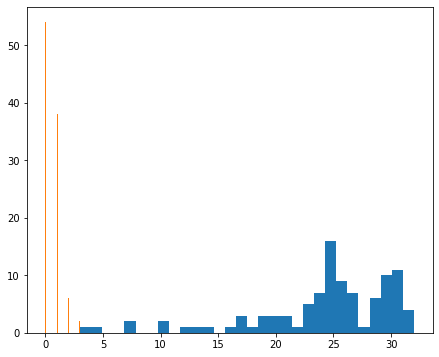

In [15]:
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,6)) #创建幕布
ax = fig.add_subplot(121) #截取幕布的一部分，121是简写，表示1行2列中的第1个图
ns,edgeBin,patches = plt.hist(positive_nums,bins=30,rwidth=1)
ns,edgeBin,patches = plt.hist(false_positive_nums,bins=30,rwidth=1)


# result 0FAR
